#Configure data and connect to database

In [1]:
from dbconnector import *
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
%matplotlib inline
%gui

In [2]:
dbconfig = get_configuration()
connection = make_connection(dbconfig)
q_devices = "Select * from datasci.devices"
q_actions = "Select *,CONCAT(year(time_stamp),'Q',quarter(time_stamp)) as timeperiod from datasci.actions"
q_products_lookup = "Select * from datasci.products_lookup"

devices = query_db(connection, q_devices)
actions = query_db(connection, q_actions)
product_lookup = query_db(connection, q_products_lookup)

In [38]:
seg_labels = ['Best Buy','Stat ind Sm','Holiday Purch']

In [4]:
segment1 = actions[actions['action_type'] == 'purchase']
segment1 = segment1[segment1['dealer'] == 'Best Buy']['user_id'].unique()
segment2 = devices[devices['item_id'] == 55]['user_id'].unique()
segment3 = actions[actions.time_stamp.map(lambda x: x.month in [10,11,12])]
segment3 = segment3[actions['action_type'] == 'purchase']['user_id'].unique()

/Users/admin/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [5]:
#counts by segment
seg_counts = np.array([len(segment1),len(segment2),len(segment3)])

In [6]:
#add segment flag columns in dataframes
devices['segment1'] = np.where(devices.user_id.map(lambda x: x in segment1),1,0)
devices['segment2'] = np.where(devices.user_id.map(lambda x: x in segment2),1,0)
devices['segment3'] = np.where(devices.user_id.map(lambda x: x in segment3),1,0)
actions['segment1'] = np.where(actions.user_id.map(lambda x: x in segment1),1,0)
actions['segment2'] = np.where(actions.user_id.map(lambda x: x in segment2),1,0)
actions['segment3'] = np.where(actions.user_id.map(lambda x: x in segment3),1,0)

#Analysis

##Per capita spend by segment

In [43]:
spend_per_capita = Series([actions[actions.segment1 == 1].item_price.sum()/len(segment1),actions[actions.segment2 == 1].item_price.sum()/len(segment2),actions[actions.segment3 == 1].item_price.sum()/len(segment3)],index = seg_labels)

In [44]:
overall_spend = Series([actions[actions.segment1 == 1].item_price.sum(),actions[actions.segment2 == 1].item_price.sum(),actions[actions.segment3 == 1].item_price.sum()],index = seg_labels)

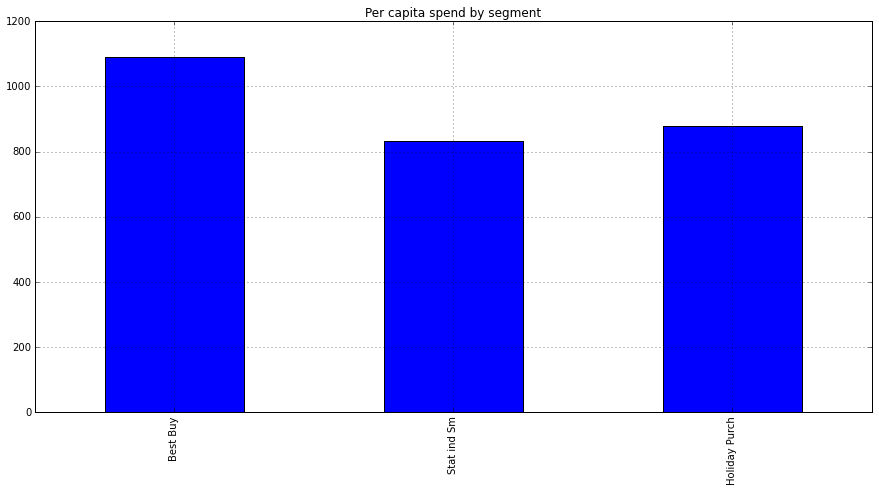

In [45]:
spend_per_cap = spend_per_capita.plot(kind='bar',title='Per capita spend by segment',figsize=(15,7),rot=90)
plt.savefig('spend_per_cap.png')

##Total spend by segment

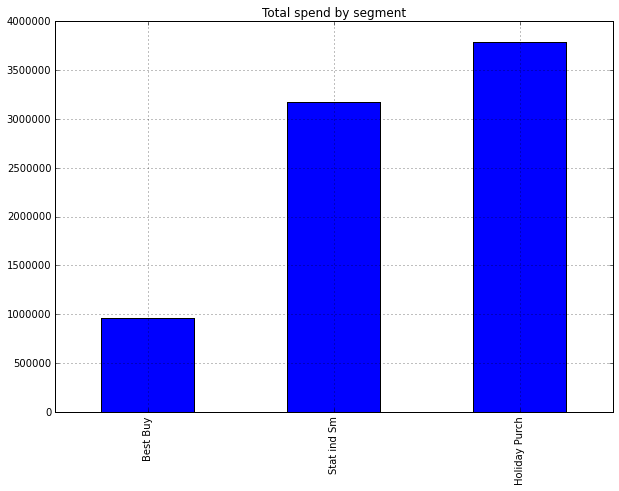

In [69]:
overall_spend.plot(kind='bar',title='Total spend by segment',figsize=(10,7))
plt.savefig('overall_spend.png')

##Frequency of purchase
Who buys the most big ticket items

In [48]:
purchased_items = actions[actions.action_type=='purchase']
seg_01_purch = purchased_items[purchased_items.segment1==1].groupby('item_name')
seg_02_purch = purchased_items[purchased_items.segment2==1].groupby('item_name')
seg_03_purch = purchased_items[purchased_items.segment3==1].groupby('item_name')

In [54]:
t1 = seg_01_purch['item_price'].count()
t2 = seg_02_purch['item_price'].count()
t3 = seg_03_purch['item_price'].count()
new_dat = DataFrame([t1,t2,t3],index=seg_labels)

In [55]:
new_dat = new_dat.drop('',axis=1)

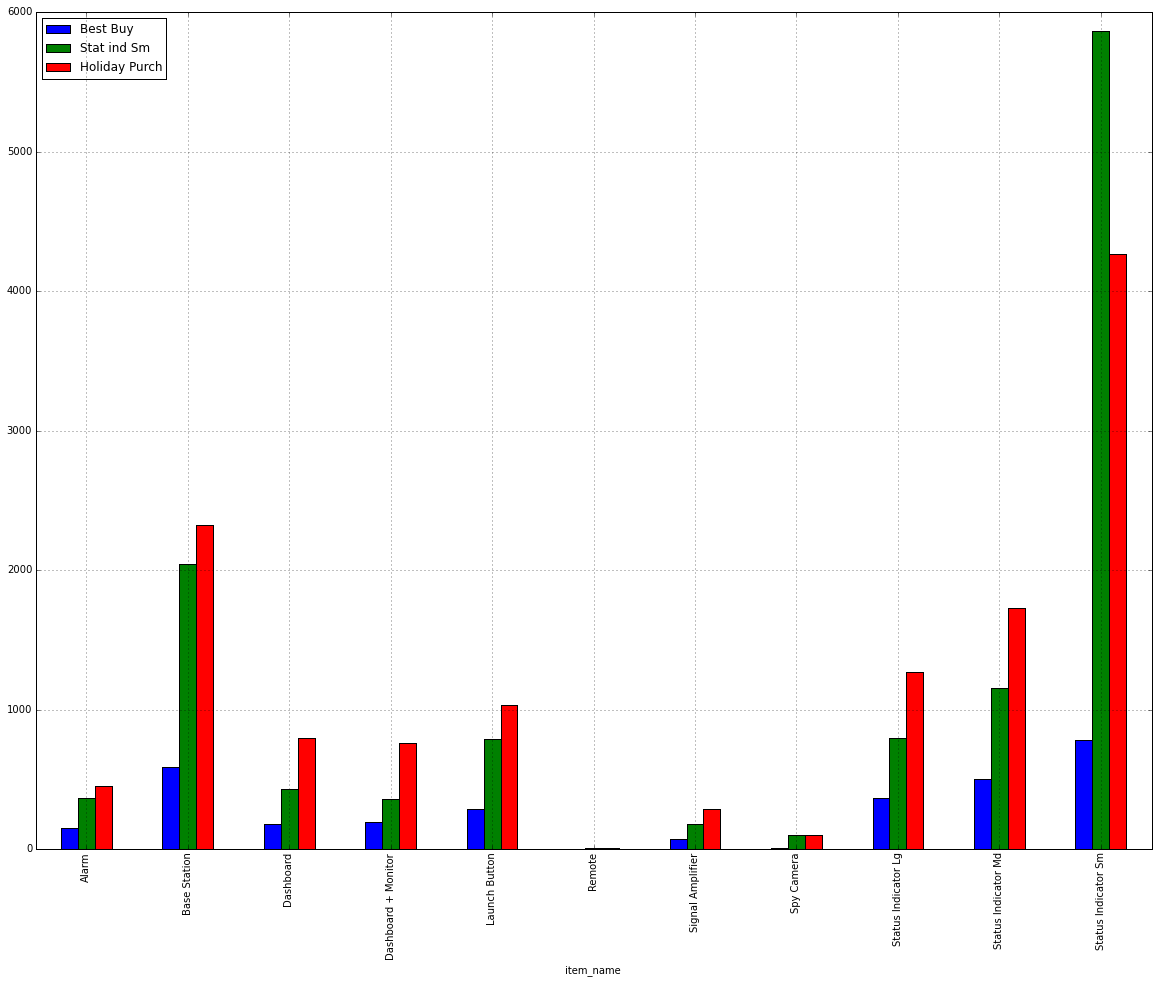

In [68]:
new_dat.T.plot(kind='bar',figsize=(20,15))
plt.savefig("Frequency_item_purchased.png")

##Seasonal purchasing?

In [58]:
quarters = actions[actions.action_type == 'purchase'].groupby('timeperiod')
quarters_seg1 = actions[actions.segment1 == 1].groupby('timeperiod')
quarters_seg2 = actions[actions.segment2 == 1].groupby('timeperiod')
quarters_seg3 = actions[actions.segment3 == 1].groupby('timeperiod')


In [59]:
segment1 = quarters_seg1['item_price'].sum()
segment2 = quarters_seg2['item_price'].sum()
segment3 = quarters_seg3['item_price'].sum()

In [60]:
df = DataFrame([segment1,segment2,segment3],index = seg_labels)

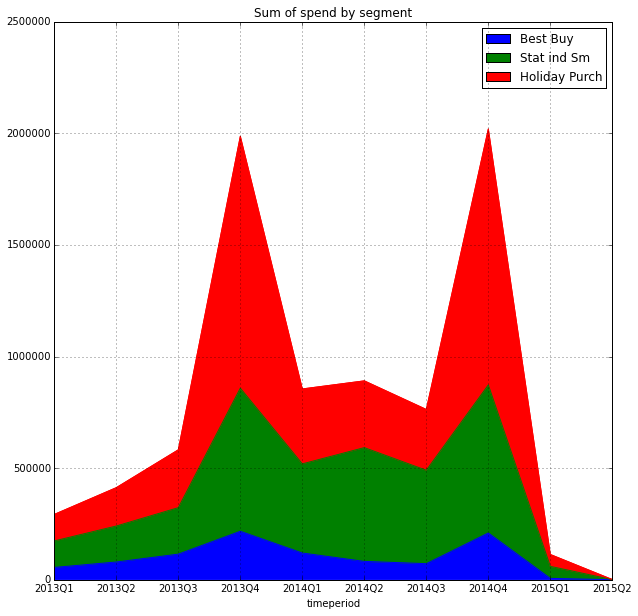

In [66]:
df.T.plot(kind='area',figsize=(10,10),title='Sum of spend by segment')
plt.savefig('spend by time.png')

##Understanding crossover by segment

In [70]:
df_unique_users = pd.merge(actions,devices,'inner',on='user_id')

In [71]:
df_unique_users = df_unique_users.drop_duplicates('user_id')

In [72]:
seg1 = df_unique_users[df_unique_users.segment1_x == 1]
seg2 = df_unique_users[df_unique_users.segment2_x == 1]
seg3 = df_unique_users[df_unique_users.segment3_x == 1]

In [73]:
seg1_seg1 = len(seg1)/float(len(seg1))
seg1_seg2 = len(seg1[seg1.segment2_x==1])/float(len(seg1))
seg1_seg3 = len(seg1[seg1.segment3_x==1])/float(len(seg1))
seg2_seg1 = len(seg2[seg2.segment1_x==1])/float(len(seg2))
seg2_seg2 = len(seg2)/float(len(seg2))
seg2_seg3 = len(seg2[seg2.segment3_x==1])/float(len(seg2))
seg3_seg1 = len(seg3[seg3.segment1_x==1])/float(len(seg3))
seg3_seg2 = len(seg3[seg3.segment2_x==1])/float(len(seg3))
seg3_seg3 = len(seg3)/float(len(seg3))

In [74]:
seg_x_seg = DataFrame([[seg1_seg1,seg1_seg2,seg1_seg3],[seg2_seg1,seg2_seg2,seg2_seg3],[seg3_seg1,seg3_seg2,seg3_seg3]],index = seg_labels,columns=seg_labels)

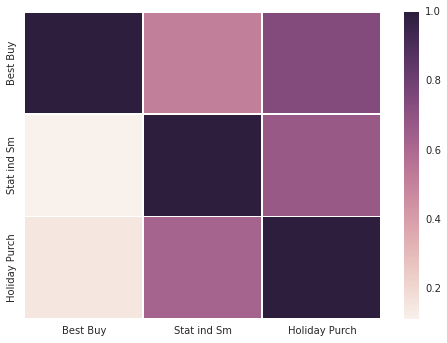

In [76]:
#create confusion matrix to show crossover between segments
from seaborn import heatmap
heat_plt =heatmap(seg_x_seg)
plt.savefig('crossover.png')